Rewrite the code in a clear way. Instead of using the terms: forward, inverese encoding, estimated weight matrices, place everything in terms of the inputs, that is: channel responses [C] and BOLD responses [B].

Motivation: Writing the code in a clearer way. This allows to debug, i.e. catch error in an easier way. Additionally, it will allow to clearly identify matrices ranks.

This code was modified from Gardner's lab tutorial on inverse encoding models.
- https://gru.stanford.edu/doku.php/tutorials/channel
- https://gru.stanford.edu/doku.php/tutorials/channel_full_code

We will use simulated tactile stimuli of frequencies: 100-340 Hz: 100, 130, 160, 190, 220, 250, 280, 310, 340.

#### Created on September 2024 by Daniela del Río, https://github.com/DanidelRio 

The underlying idea is that every voxel (channel responses) is modeled as the linear sum of underlying populations of neurons (channel responses) tuned to different orientations.

The BOLD response for every stimuli is a weighted sum of the channel responses.
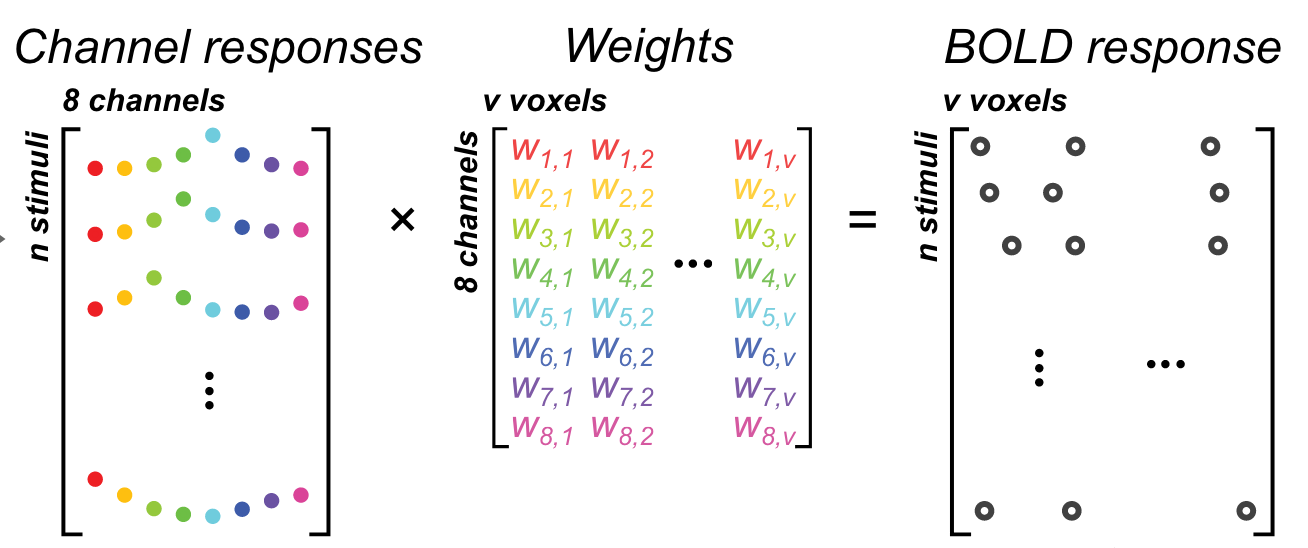

See Gardner and Liu, 2018.

$$C W = B$$

In forward encoding, we know the channel response matrix and the BOLD response matrix. So we solve for the weight matrix. For example, using the least-squares regression.

In inverse encoding, using the BOLD response matrix and an estimated weight matrix, we solve for the channel responses.


### Parts of the channel encoding model tutorial:
1. Simulating data for fitting the model.
    - Obtain channel response (C) and BOLD response (B) matrices.
2. Perform forward encoding.
    - Fitting the weight matrix to the simulated data.
    $$ W = C^\dagger B$$
    
    Question: Why calculate the pseudoinverse of a matrix?
$$C  W = B$$
$$C^\dagger C W = C^\dagger B$$
$$\mathrm(1) W = C^\dagger B$$
$$W = C^\dagger B$$
Note that $C^\dagger$ is the pseudoinverse of C.

3. Computing the goodness-of-fit. $r^2$
4. Inverting the encoding model.
    - Solving for the channel response matrix (C) using the estimated weight matrix (W).
    - Note on cross-validation. Dividing voxel response (B) in 2 parts (train and test voxel response) to test the model's ability to predict new data that was not used in estimating it.
    
    $$C = B W^\dagger$$
5. Use a simplified Bayesian algorithm to determine stimulus likelihood.
    - Stimulus likelihood function is the probability of any stimulus given a particular response. Requirements: mean response and variance around the mean response. This is obtained from the residuals once the encoding model is fitted. For example, fit a multi-variate gaussian noise model to these residuals.
    - Compute the multivariate gaussian probability distribution.
    - Note: The channel responses depend on the basis/kernel we use. In this case, we assumed them to be linear. If we assumed them to be bimodal, that is what we would obtain.

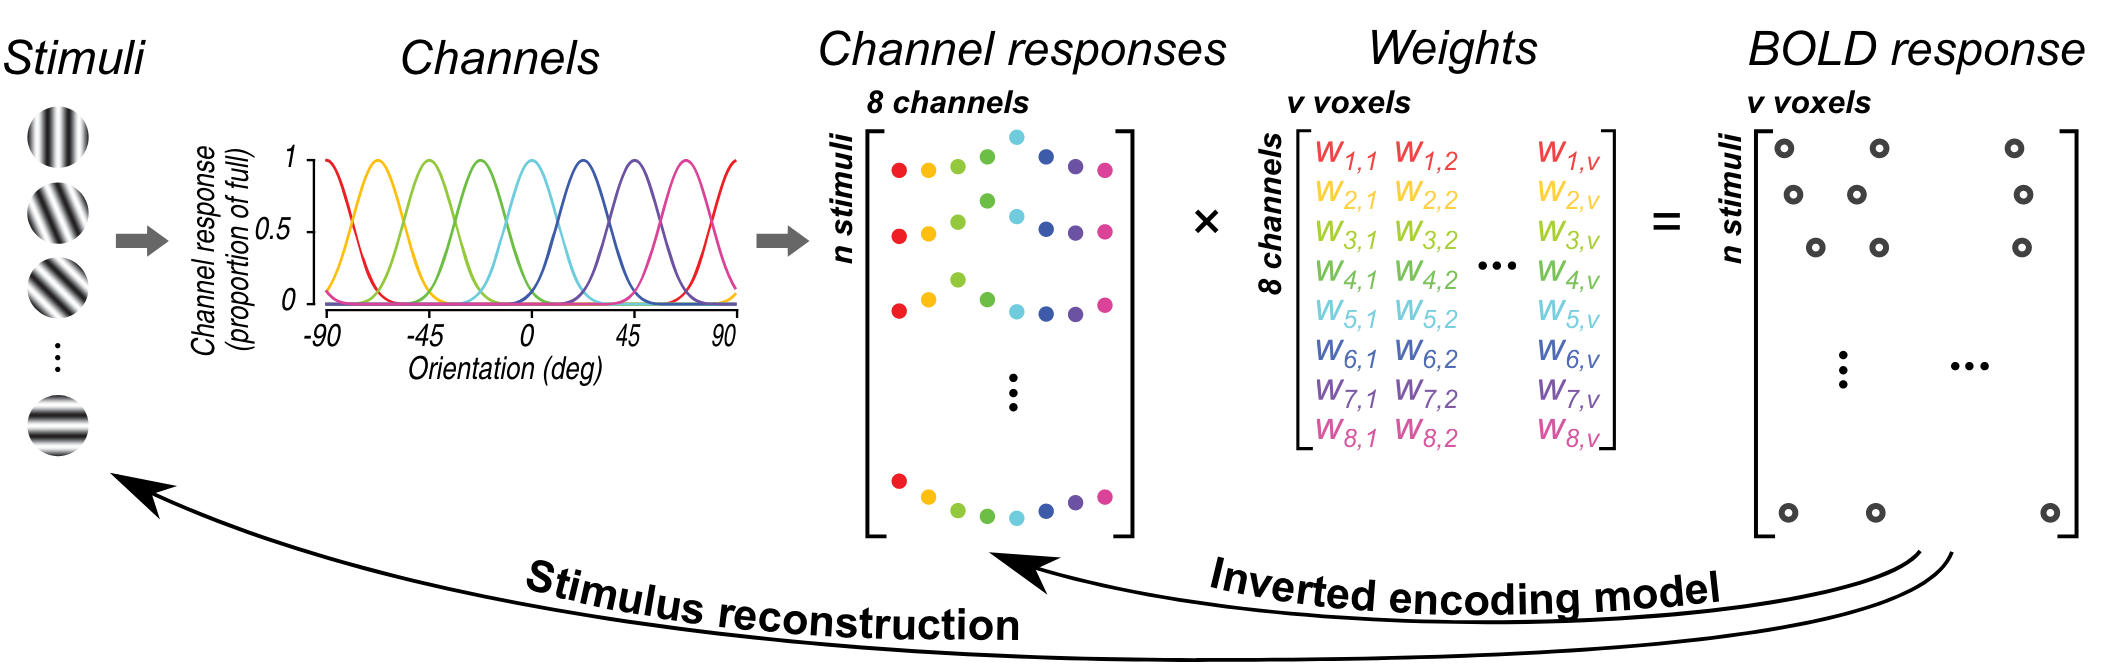
See Gardner and Liu, 2018.


A question that drove the rewriting is: Is it valid to express B as the product of smaller ranked matrices? Is matrix multiplication invariant under matrix decomposition? The answer is: no. Here is another question. Would the analysis followed by Gardner and Liu change anything if the B matrix diminished its rank, that is, we first considered a certain number of voxels and we then considered another number of voxels? Let's look at the ranks

- Channel responses [C]
- Weights [W]
- BOLD response [B]
t-index inticates the division index between train and test trials.

Notation note: $\hat{W}$ indicates the estimated weight matrix, analogous, $\hat{B}$ indicates the predicted BOLD responses.

$$[C] = n-trials \ \times \ k-channels$$
$$[W] = k-channels \ \times \ v-voxels$$
$$[B] = n-trials \ \times \  v-voxels$$

However, the data is divided into trial and test. 
$$[C_1] = t \times k$$
$$[C_2] = n-t \times k$$
$$[B_1] = t \times v$$
$$[B_2] = n-t \times v$$

Note: The rank of the pseudoinverese is the same as the original matrix, regardless if it's square or not. Let 
$$[A] = n \times m$$
$$[A^\dagger] = m \times n$$



Coming back to the question about first calculating the BOLD response for a fixed number of voxels and then for another number of voxels, yes. That is a valid thing to do.

We know the estimated weight matrix $[\hat{W}]$ is given by:
$$\hat{W} = C_1^\dagger B_1$$
$$[C_1^\dagger B_1] \ = \ (t \times v)^\dagger \ (t \times v) \ = \ (k \times t) \ (t \times v) \ = \ k \times v$$
$$[\hat{W}] \ = \ k \times v$$

Now, for the predicted BOLD responses $[\hat{B}]$
$$\hat{B} = C_2 \hat{W}$$
$$[C_2 \hat{W}] \ = \ (n-t \times k) \ (k \times v) \ = \ n-t \times v$$
$$[\hat{B}] \ = \ n-t \times v$$

Cool. Note that we can rewrite $\hat{B}$ in terms of $C_1$, $C_2$ and $B_1$. Let's do that.
$$\hat{B} = C_2 C_1^\dagger B_1$$

Additionally, note $C_2 C_1^\dagger$ do not depend on the number of voxels!
$$[C_2 C_1^\dagger] \ = \ [n-t \times k] \ [t \times k]^\dagger \ = \ [n-t \times t]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import time

from scipy.stats import multivariate_normal, pearsonr, ttest_ind
from scipy.optimize import curve_fit

### Create simulated stimuli, channel responses [C] and BOLD responses [B]

Tactile frequencies: 100, 130, 160, 190, 220, 250, 280, 310 and 340.

In [2]:
# make channel basis functions
# channelResponse C, [nxk]
def create_channel_basis(stimuli, nChannels = 9, exponent = 7, nStimuli = 9, nRepeats = 20):
    # Note in this case, the number of channels is the same as the number of stimuli.

    frequency_range = np.arange(100, 341)
    prefStimuli = [i*30+100 for i in range(nStimuli)]

    channelBasis = np.zeros((241, nChannels)) # ideal channel responses to each of 210 frequencies
    
    # Creates the channel basis
    for iChannel in range(nChannels):
        # The output of this channel basis might be something different than expected.
        thisChannelBasis =  np.cos(2*np.pi*(frequency_range-prefStimuli[iChannel])/360)
        # rectify
        thisChannelBasis[thisChannelBasis<0] = 0
        thisChannelBasis = thisChannelBasis**exponent
        channelBasis[:,iChannel] = thisChannelBasis
        
    # Computes the channelResponse for each trial
    nTrials = nStimuli * nRepeats # 180, now 90

    C = np.zeros((nTrials, nChannels))
    
    for iTrial in range(nTrials):
        C[iTrial, :] = channelBasis[stimuli[0][iTrial]-100,:]
        
    return channelBasis, C



# Implementing the inverted encoding model
# Inputs: channelResponse, voxelResponse
# Outputs: estimatedWeights, modelPrediction, estimatedChannelResponse, testVoxelResponse, residualResponse, r2

# voxelResponse B, [nxv]
# channelResponse C, [nxk]
# Note: channelBasis != channelResponse. The channelResponse is C.

def model_fit_to_likelihoods(C, B, channelBasis, stimuli_length, nVoxels, nFolds=2, nRepeats = 20):
    
    nTrials = C.shape[0]   

    nHalfData = int(nTrials/nFolds)
    half_nConsecutiveSameTrials = int(nRepeats/2)
    first_half_vec = np.zeros(nHalfData, np.int64)
    second_half_vec = np.zeros(nHalfData, np.int64)
    index = 0

    for k in range(int(nTrials/nRepeats)):
        for i in range(half_nConsecutiveSameTrials):
            first_half_vec[index] = nRepeats*k + i
            second_half_vec[index] = nRepeats*k + i + half_nConsecutiveSameTrials
            index += 1

    B1 = B[first_half_vec] # trainVoxelResponse (B1) [txv]
    B2 = B[second_half_vec] # testVoxelResponse (B2) [n-txv]
    
    C1 = C[first_half_vec]
    C2 = C[second_half_vec]
    
    W_estimated = np.matmul(np.linalg.pinv(C1), B1) # Computes the (Moore-Penrose) pseudo-inverse of C1
    B_predicted = np.matmul(C2, W_estimated) # model prediction on test data
    C_estimated = np.matmul(B2, np.linalg.pinv(W_estimated)) # estimated channel responses from B2 and W_estimated^T
    
    # compute residual
    residualResponse = B2 - B_predicted
    residualVariance = np.var(residualResponse) # a scalar value
    
    # compute r2 for the decoded model
    r2 = 1 - residualVariance / np.var(B2)

    
    # Calculating the stimulus likelihoods
    
    # Diagonal elements of the matrix are the variance computed across all voxels.
    # Off diagonals (in this case all 0) contain covariance between voxels
    modelCovar = np.identity(nVoxels) * residualVariance
    
    # cycle over each trial
    nTestTrials = np.size(B2, 0) # n-t
    likelihood = np.zeros([nTestTrials, stimuli_length]) # n-t, 9
    
    for iTrial in range(nTestTrials):

        for iStimulus in range(stimuli_length): # 211 iterations
            # compute the mean voxel response predicted by the channel encoding model
            # For the same stimulus, B_predicted is always the same.
            B_predicted = np.matmul(channelBasis[iStimulus], W_estimated)
            # The probability of a stimulis is given by the mean response and the model covariance.

            # HERE!! J: the predictedResponse can be expanded in the domain.
            mvnpdf = multivariate_normal.pdf(B2[iTrial], mean=B_predicted, cov = modelCovar)
            likelihood[iTrial,iStimulus] = mvnpdf
    
    return W_estimated, B_predicted, C_estimated, B1, B2, residualResponse, r2, likelihood



# Used to fit a gaussian to each trial.
def gaussian(x, mu, sigma, amplitude):
    coefficient = amplitude/ np.sqrt(2*np.pi*sigma**2)
    return coefficient*np.exp(-(x-mu)**2/(2*sigma**2))



# Function that given a vector, replicates the first 50 and last 50 entries of the array.
# The vector should be at least length 100
# Used as a supplementary to `curve_fit`
def mirror_edges(vector, cushion=10):
    
    length = len(vector)
    
    if length < cushion*2:
        print("Vector less than 100 entries")
        
    else:
        beginning = np.flip(vector[0:cushion])
        ending = np.flip(vector[length-cushion:length])
        
    return np.concatenate((beginning, vector, ending))

In [6]:
# Inputs nfrequencies
def gaussian_fit(probability, cushion = 10):

    # Fitting a gaussian to all the test trials
    nTestTrials, nfrequencies = probability.shape

    xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
    xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

    means_vec = np.zeros(nTestTrials)
    sigmas_vec = np.zeros(nTestTrials)
    amplitudes_vec = np.zeros(nTestTrials)

    for trial_i in range(nTestTrials): # 90 iterations. THESE INDICES SHOULD SPAN THE ACTUAL SPACE
        ydata = probability[trial_i, :]
        ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES.
        # J Note: mirroring the probability in the edges destroys the noise effects

        p0 = [probability[trial_i,:].argmax(), 0.5, 1] # initial guess

        try:
            gaussian_fit = curve_fit(gaussian, xdata, ydata_mirror, p0)
            # gaussian takes: x, mu, sigma, amplitude
        except RuntimeError:
            print("Error fitting gaussian in: ",trial_i)
            gaussian_fit = [['nan', 'nan', 'nan']]

        means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = gaussian_fit[0]

    return means_vec, sigmas_vec, amplitudes_vec

# Running the simulation

# B comes from the `Data_analysis_What_voxels_to_use`

In [7]:
# Function that obtains the relative distance between the values xx and yy, i.e. a divergence function.
# The relative error is pondered by the interval of maximum and minimum values vary across the 2 folds.
# xx and yy are 1-dimensional vectors with 9 entries (frequencies)
def relative_error(xx, yy):
    all_entries = np.concatenate((xx, yy))
    
    maximum = np.max(all_entries)
    minimum = np.min(all_entries)
    
    relative_error = [np.abs(xx[i]-yy[i])/(maximum-minimum) for i in range(len(xx))]    
    
    return np.mean(relative_error)

In [9]:
# # All the data is here!
# subj = 'Data_betas/Betas/FreqAP02'
# hand = 'L'
# # vox1 = np.load(subj+'_N1L1.npy')
# # vox2 = np.load(subj+'_N1L2.npy')

# matrix1 = np.load(subj+'_N1L1.npy')
# matrix2 = np.load(subj+'_N1L2.npy')

In [10]:
# THis is only the first 20000 datapoints
data = np.load('Data_betas/Betas/FreqAP02_L_1.npz') # 20000 datapoints from fold 1 and 20000 from fold 2
lst = data.files
print(type(lst)) # list
matrix1 = data['arr_0'] # array with beta coefficients, fold 1
matrix2 = data['arr_1'] # array with beta coefficients, fold 2
    
data.close()

<class 'list'>


In [11]:
# Calculating the data

condition = 0 # Out of 4 conditions

m1 = matrix1[:, condition:9*(condition+1)]
m2 = matrix2[:, condition:9*(condition+1)]

length = m1.shape[0]

absolute_err_vec = [np.mean(np.abs(m1[i] - m2[i])) for i in range(length)]
absolute_err_1_vec = [1-np.mean(np.abs(m1[i] - m2[i])) for i in range(m1.shape[0])]
relative_err_vec = [relative_error(m1[i], m2[i]) for i in range(length)]
relative_err_1_vec = [1-(relative_err_vec[i]) for i in range(length)]
pearson_cross_correlation = [pearsonr(m1[i], m2[i])[0] for i in range(length)]

# 2 BIRDS IN ONE SHOT.
# Of the voxels that have a meet 2 criteria, plot what is the distribution
exclusion_criteria_pearson = 0.6
exclusion_criteria_relative = 0.75

indices_pearson = []
indices_relative = []
indices_both = []

mask_both = [False for i in range(length)]
mask_pearson_only = [False for i in range(length)]
mask_relative_only = [False for i in range(length)]

for i in range(length):
    
    if pearson_cross_correlation[i] > exclusion_criteria_pearson: # voxel is included in mask_both or mask_pearson_only
        indices_pearson.append(i)
        
        if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel meets both criteria.
            indices_relative.append(i)
            indices_both.append(i)
            mask_both[i] = True
            
        else: # voxel only meets Pearson criteria.
            mask_pearson_only[i] = True
            
    if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel is not considered in a traditional analysis!
        indices_relative.append(i)
        mask_relative_only[i] = True
        
print("Percentage of included voxels with Pearson criteria:",len(indices_pearson)/length*100)
print("Percentage of included voxels with 1-Relative exclusion criteria:",len(indices_relative)/length*100)
print("Percentage of included voxels that meet both criteria:",len(indices_both)/length*100)
print("Number of included voxels that meet both criteria:",len(indices_both))


# Using the Pearson indices criteria
# values_relative = [relative_err_vec[exclusion_indices_pearson[i]] for i in range(len(exclusion_indices_pearson))]
pearson_index_values_pearson = [pearson_cross_correlation[indices_pearson[i]] for i in range(len(indices_pearson))]
pearson_index_values_relative = [relative_err_1_vec[indices_pearson[i]] for i in range(len(indices_pearson))]

# Using the relative indices criteria
relative_index_values_pearson = [pearson_cross_correlation[indices_relative[i]] for i in range(len(indices_relative))]
relative_index_values_relative = [relative_err_1_vec[indices_relative[i]] for i in range(len(indices_relative))]

# Using both indices criteria
both_index_values_pearson = [pearson_cross_correlation[indices_both[i]] for i in range(len(indices_both))]
both_index_values_relative = [relative_err_1_vec[indices_both[i]] for i in range(len(indices_both))]

Percentage of included voxels with Pearson criteria: 4.465
Percentage of included voxels with 1-Relative exclusion criteria: 17.794999999999998
Percentage of included voxels that meet both criteria: 3.1399999999999997
Number of included voxels that meet both criteria: 628


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


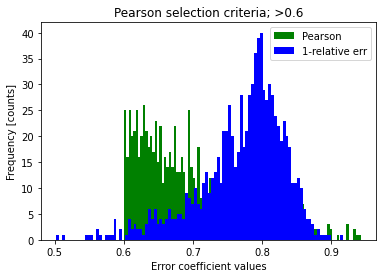

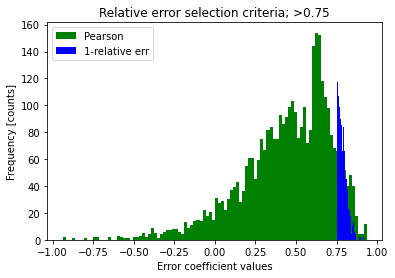

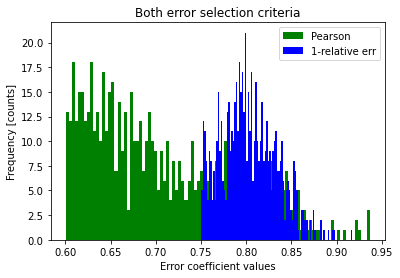

In [12]:
# Histogram plots: Pearson selection criteria
plt.hist(pearson_index_values_pearson, color='g', bins=100, label = "Pearson")
plt.hist(pearson_index_values_relative, color='b', bins=100, label = "1-relative err")

label_p = "Pearson selection criteria; >" + str(exclusion_criteria_pearson)
plt.xlabel("Error coefficient values")
plt.ylabel("Frequency [counts]")
plt.title(label_p)
plt.legend()
plt.show()


# Histogram plots: Relative error criteria
plt.hist(relative_index_values_pearson, color='g', bins=100, label = "Pearson")
plt.hist(relative_index_values_relative, color='b', bins=100, label = "1-relative err")

label_r = "Relative error selection criteria; >" + str(exclusion_criteria_relative)
plt.xlabel("Error coefficient values")
plt.ylabel("Frequency [counts]")
plt.title(label_r)
plt.legend()
plt.show()


# Histogram plots: Both selection criteria
plt.hist(both_index_values_pearson, color='g', bins=100, label = "Pearson")
plt.hist(both_index_values_relative, color='b', bins=100, label = "1-relative err")

plt.xlabel("Error coefficient values")
plt.ylabel("Frequency [counts]")
plt.title("Both error selection criteria")
plt.legend()
plt.show()

Note the model accepts the B matrix where the BOLD coefficients for the same trial condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition. `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.

In [14]:
v_length = m1[mask_both].shape[0]
s_length = m1[mask_both].shape[1]
B = np.zeros((v_length, s_length * 2))

B = np.array([
    [m1[mask_both][k][i//2] if i % 2 == 0 else m2[mask_both][k][i//2] for i in range(s_length * 2)]
    for k in range(v_length)]).T
B.shape

(18, 628)

In [18]:
start_time = time.time()
# How much time is this taking to run? https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution

# Initializing variables
nStimuli = 9
nRepeats = 2 # These are the number of overall BOLD coefficients in the big matrix. At least the same as nFolds.
# nNeurons = 120
sigma = 10
nVoxels = m1[mask_both].shape[0] # number of voxels

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

# noiseStandardDeviation = 0.1 # 0.4
nFolds = 2
nfrequencies = 241
initial_frequency = 100
print("nVoxels", nVoxels)

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([[tactile_stimuli[i] for k in range(nRepeats)] for i in range(len(tactile_stimuli))]).reshape(1,nStimuli*nRepeats)
stimuli = np.round(stimuli)
stimuli = stimuli.astype(np.int64)

frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies


channelBasis, C = create_channel_basis(stimuli, nChannels, exponent, nStimuli, nRepeats)
print("Data ready.")
W_estimated, B_prediction, C_estimated, B1, B2, residualResponse, r2, likelihood = model_fit_to_likelihoods(C, B, channelBasis, nfrequencies, nVoxels, nFolds, nRepeats)
print("Model fit ready.")


# Obtaining probability vector, aka normalizing likelihood across trials
trials_length, frequencies_length = likelihood.shape
probability = np.zeros([trials_length, frequencies_length])

for trial_i in range(trials_length): # 80 iterations

    upper_lim = max(likelihood[trial_i,:])
    lower_lim = min(likelihood[trial_i,:])

    # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
    probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)


# Fitting gaussians to all the trials 
means_vec, sigmas_vec, amplitudes_vec = gaussian_fit(probability, cushion = 10)
print("Gaussian fit ready.")
n_half_consecutive = int(nRepeats/2)

# Organizing the values for boxplots:
auxiliary = [i+1 for i in range(nStimuli)]
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli_aux = np.asarray([[auxiliary[i] for k in range(n_half_consecutive)] for i in range(len(tactile_stimuli))]).reshape(1,round(nStimuli*nRepeats/2))

stimuli_organized = np.asarray([[tactile_stimuli[i] for k in range(n_half_consecutive)] for i in range(len(tactile_stimuli))])
means_organized = [np.asarray(means_vec[n_half_consecutive*i:n_half_consecutive*i+n_half_consecutive]+initial_frequency) for i in range(nStimuli)]
sigmas_organized = [np.asarray(sigmas_vec[n_half_consecutive*i:n_half_consecutive*i+n_half_consecutive]) for i in range(nStimuli)]
amplitudes_organized = [np.asarray(amplitudes_vec[n_half_consecutive*i:n_half_consecutive*i+n_half_consecutive]) for i in range(nStimuli)]

# Measure the inverted encoding_accuracy
mean_error = np.abs(means_organized - stimuli_organized)

conditionsN, repetitionsN = mean_error.shape
average_error_per_condition = np.zeros(conditionsN)

for i in range(conditionsN):
    error_no_nans_i = mean_error[i][~np.isnan(mean_error[i])] # Removes nans
    # https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array
    # Note: removing nans destroys the 9*10 array structure, converting it to a big array.
    average_error_per_condition[i] = np.mean(error_no_nans_i)
    
simulation_time = time.time() - start_time

print("--- %s seconds ---" % simulation_time) # Converts any value into a string.

nVoxels 628
Data ready.
Model fit ready.
Gaussian fit ready.
--- 68.99785614013672 seconds ---


# Plotting every step of the simulation.

## Voxel Response

In [21]:
# Obtain the similarity plot
nTrials = stimuli.shape[1]
matrix = np.zeros([nTrials, nTrials])

for i in range(nTrials):
    for j in range(nTrials):
        matrix[i, j] = pearsonr(B[i,:], B[j,:])[0]

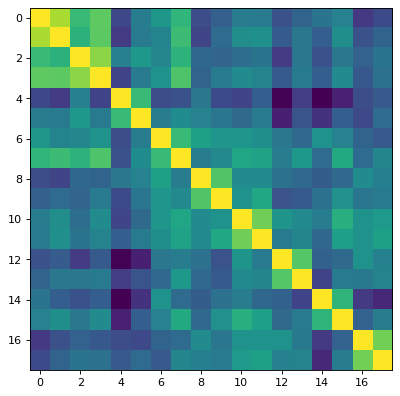

In [22]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(matrix)
plt.show()

## Channel Basis Functions

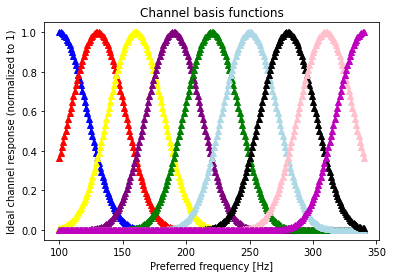

In [23]:
# Plot the mean estimatedChannelResponse for each stimulus type 
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink', 'm']

for i in range(nStimuli):
    plt.plot(frequency_range, channelBasis[:,i], c=colors[i], marker="^") #, label=stimuli[0,i*10])
    
plt.title("Channel basis functions")
plt.xlabel('Preferred frequency [Hz]')
plt.ylabel('Ideal channel response (normalized to 1)')
plt.show()

## Decoding Model Accuracy and Estimated Channel Responses

In [24]:
print("Model performance that is not cross-validated",r2)

Model performance that is not cross-validated 0.6142985819195499


# Neural noise is between 0.4 and 0.5 in the model we were playing with to replicate this level of r^2 decoding accuracy (see notes Thu, Sep 12).

# Note: What info does this C_estimated have?

Is the decoding working properly?

In [25]:
C_estimated.shape

(9, 9)

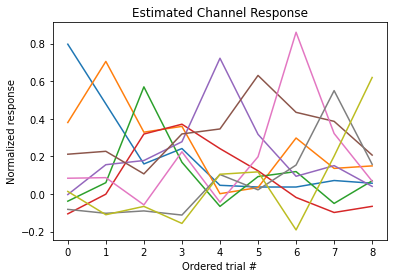

In [26]:
# I expect to see 9 peaks in this graph.
plt.plot(C_estimated)
plt.xlabel('Ordered trial #')
plt.ylabel('Normalized response')
plt.title('Estimated Channel Response') # [B2 * W_estimated^T] = n-t * k
plt.show()

## Inverted Encoding Model Outputs

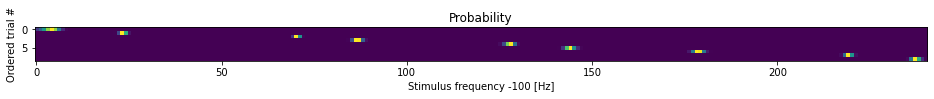

In [27]:
plt.figure(figsize=(16, 8))
plt.imshow(probability)
plt.xlabel('Stimulus frequency -100 [Hz]')
plt.ylabel('Ordered trial #')
plt.title('Probability')
plt.show()

In [28]:
# Create a function that detects peaks. How many peaks are there per condition?
def peak_detection(vec, threshold=0.1):
    
    banner = False
    peaks_i = 0
    
    for i in range(len(vec)):
        
        if vec[i] > threshold:
            if banner == False: # There is only 1 peak when the threshold is surpassed
                peaks_i +=1
                banner = True
                
        elif vec[i] < threshold and banner== True: # Resetting the banner.
            banner = False
    return peaks_i

# Fitting a gaussian to these trials

Number of peaks:  1


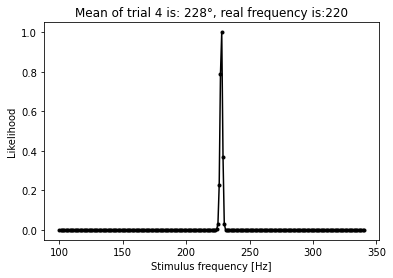

In [29]:
# Single trial, 80 possible trials
trial_i = 4
likely_stimuli = probability[trial_i,:].argmax()
all_freq_stimuli = [i+100 for i in range(241)]
print("Number of peaks: ", peak_detection(probability[trial_i,:]))

label = "Mean of trial " + str(trial_i) + " is: " + str(likely_stimuli+100) + "°, real frequency is:" + str(stimuli_organized.reshape(1, probability.shape[0])[0][trial_i])

plt.plot(all_freq_stimuli, probability[trial_i,:], marker=".", c="k")
plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Likelihood')
plt.show()

# Plot all the channel responses.

[3.79604325 1.71948296 4.25382866]
[23.27416804  0.70512227  1.90687604]
[70.24457026  0.62137759  1.6834807 ]
[86.52240151  0.87275251  2.5662412 ]
[127.67271496   0.92863993   2.44361835]
[143.84008703   0.97632541   2.49565422]
[178.48436991   1.05636297   2.9302073 ]
[219.11233954   0.76726316   1.94609835]
[237.18897377   0.85317438   2.17597402]


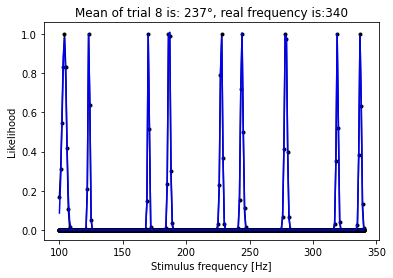

In [30]:
# Single trial
trials = [i for i in range(9)]

for trial_i in range(len(trials)):
# trial_i = 1

    xdata = [i for i in range(241)]

    ydata = probability[trial_i,:]

    p0 = [probability[trial_i,:].argmax(), 0.5, 1]

    # Using non-lionear least squares to fit the data
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    gaussian_fit = curve_fit(gaussian, xdata, ydata, p0)
    print(gaussian_fit[0])
    mean, sigma, amplitude = gaussian_fit[0]

    a, b = stimuli_organized.shape

    label = "Mean of trial " + str(trial_i) + " is: " + str(round(mean)) + "°, real frequency is:" + str(stimuli_organized.reshape(1, a*b)[0][trial_i])

    plt.plot(all_freq_stimuli, probability[trial_i,:], marker=".", c="k")

    plt.plot(all_freq_stimuli, gaussian(xdata, mean, sigma, amplitude), c="b")

    plt.title(label)
    plt.xlabel('Stimulus frequency [Hz]')
    plt.ylabel('Likelihood')
    # plt.xlim([-1,50])
    # plt.xlim([150,200])
plt.show()

### What is the overall behavior of all the means and sigmas organized by stimulus frequency?

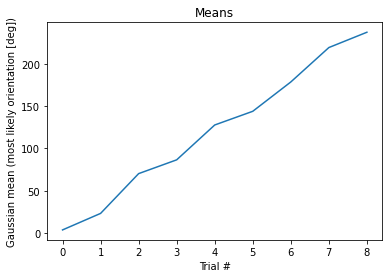

In [31]:
plt.plot(means_vec)
plt.title("Means")
plt.xlabel('Trial #')
plt.ylabel('Gaussian mean (most likely orientation [deg])')
plt.show()

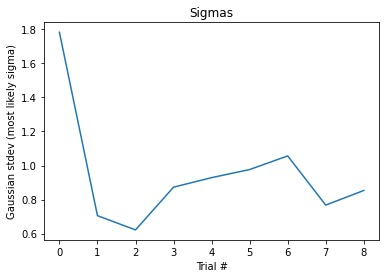

In [32]:
plt.plot(sigmas_vec)
plt.title("Sigmas")
plt.xlabel('Trial #')
plt.ylabel('Gaussian stdev (most likely sigma)')
plt.show()

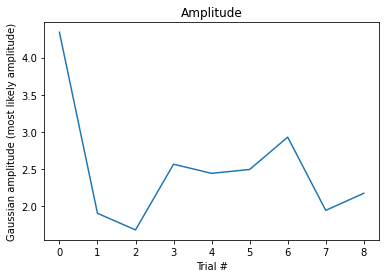

In [33]:
plt.plot(amplitudes_vec)
plt.title("Amplitude")
plt.xlabel('Trial #')
plt.ylabel('Gaussian amplitude (most likely amplitude)')
plt.show()

### Visualizing the previous data using boxplots.

In [34]:
labels = [100+i*30 for i in range(9)]

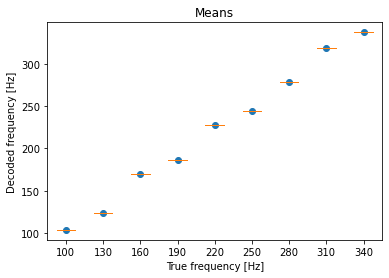

In [35]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# If a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(means_organized) # means_organized is a 9*10 vector
plt.scatter(stimuli_aux, means_organized) # 90-entry vector

ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Decoded frequency [Hz]')
plt.title("Means")
plt.show()

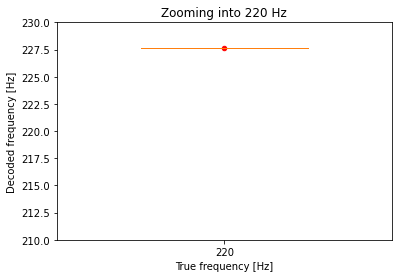

In [36]:
# Zooming into the previous plot

fig, ax = plt.subplots()

ax.boxplot(means_organized)#, notch=True, labels = stimuli_1)
plt.scatter(stimuli_aux, means_organized, s=20, c='r')

plt.ylim([210, 230])
plt.xlim([4.5, 5.5])

ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Decoded frequency [Hz]')
plt.title("Zooming into 220 Hz")
plt.show()

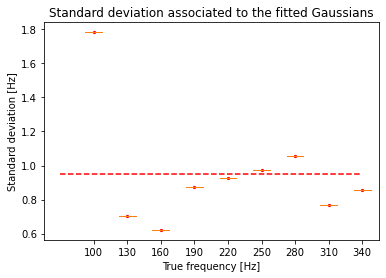

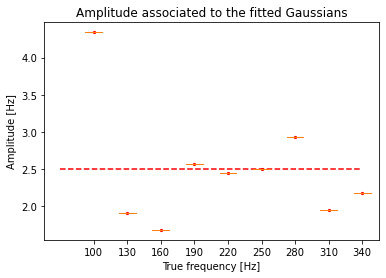

In [37]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(sigmas_organized)#, notch=True, labels = stimuli_1)
plt.scatter(stimuli_aux, sigmas_vec, s=5, c='r')
# plt.ylim([-1, 5])

plt.hlines(np.mean(sigmas_organized), 0, 9, linestyle='dashed', colors = 'r')
ax.set_xticklabels(labels)

# plt.ylim([20, 28])
# plt.xlim([1.5, 2.5])

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Standard deviation [Hz]')
plt.title("Standard deviation associated to the fitted Gaussians")
plt.show()

# Amplitudes
fig, ax = plt.subplots()
ax.boxplot(amplitudes_organized)#, notch=True, labels = stimuli_1)
plt.scatter(stimuli_aux, amplitudes_organized, s=5, c='r')
# plt.ylim([-1, 5])
plt.hlines(np.mean(amplitudes_organized), 0, 9, linestyle='dashed', colors = 'r')
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Amplitude [Hz]')
plt.title("Amplitude associated to the fitted Gaussians")
plt.show()

In the 340 Hz trials, the sigmas have higher values. This might be related to the estimatedChannelResponses?

The lower sigmas for 100 and 310 Hz might be some kind of border effect?

### Ploting the overlay of the trials for the same condition over the 9 stimuli.

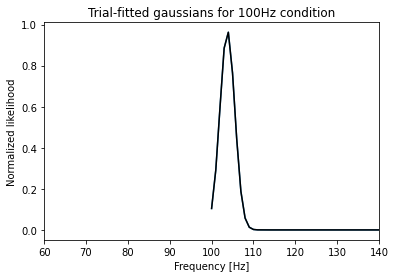

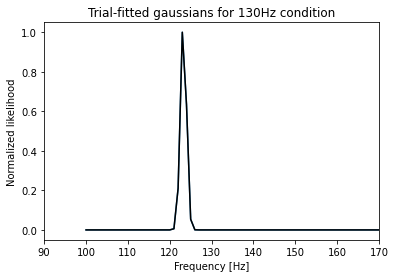

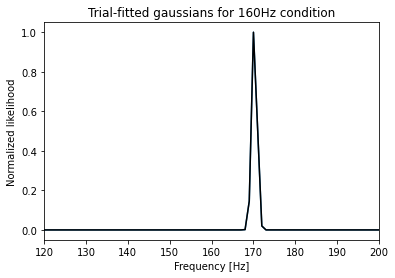

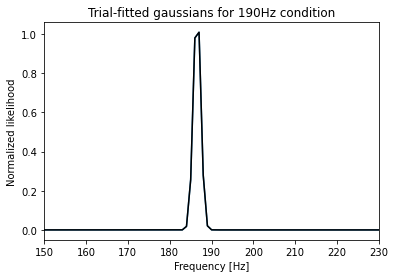

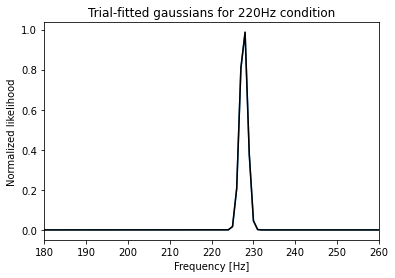

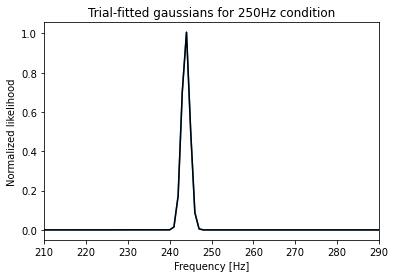

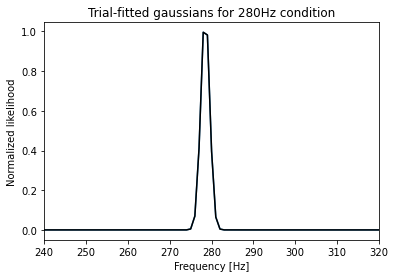

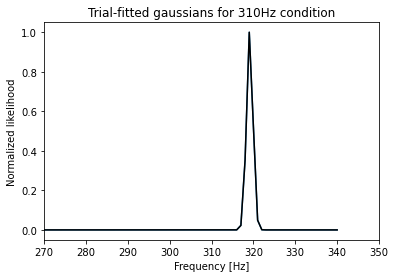

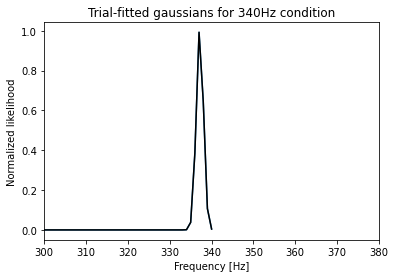

In [38]:
window = 40
for stim_i in range(len(means_organized)):
    xdata = [i+100 for i in range(nfrequencies)]
    
    mean = np.mean(means_organized[stim_i])
    sigma = np.mean(sigmas_organized[stim_i])
    amplitude = np.mean(amplitudes_organized[stim_i])
    
    for rep_i in range(len(means_organized[stim_i])):
        mean = means_organized[stim_i][rep_i]
        sigma = sigmas_organized[stim_i][rep_i]
        amplitude = amplitudes_organized[stim_i][rep_i]

        y_ind = gaussian(xdata, mean, sigma, amplitude)    
        plt.plot(xdata, y_ind)   

    yy = gaussian(xdata, np.mean(means_organized[stim_i]), sigma, amplitude)

    plt.plot(xdata, yy, c='k')
    plt.xlim([stimuli_organized[stim_i][0]-window, stimuli_organized[stim_i][0]+window])
    plt.xlabel(r'Frequency [Hz]')
    plt.ylabel(r'Normalized likelihood')
    plt.title("Trial-fitted gaussians for "+str(stimuli_organized[stim_i][0])+"Hz condition")

    plt.show()

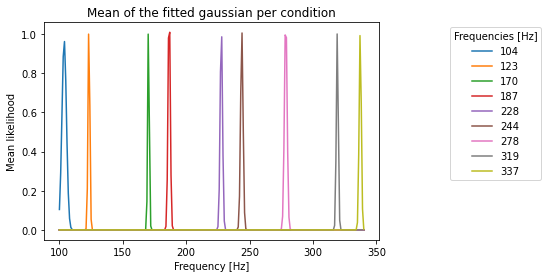

In [39]:
for stim_i in range(len(means_organized)):
    xdata = [i+100 for i in range(nfrequencies)]
    
    mean = np.mean(means_organized[stim_i])
    sigma = np.mean(sigmas_organized[stim_i])
    amplitude = np.mean(amplitudes_organized[stim_i])

    yy = gaussian(xdata, np.mean(means_organized[stim_i]), sigma, amplitude)
    
    label_Hz = str(round(mean))
    plt.plot(xdata, yy, label=label_Hz)
    
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Mean likelihood')    
plt.title("Mean of the fitted gaussian per condition")
plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")
# plt.legend()
plt.show()

### When does the model break?
### Calculating the error of the fitted gaussian's mean compared to the real frequency.
### Inverted decoding accuracy
### Calculating the error per condition.

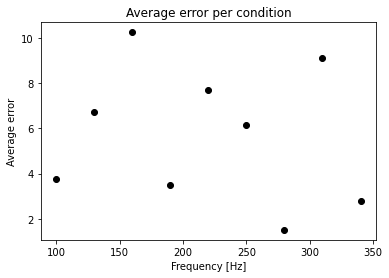

In [40]:
plt.scatter(tactile_stimuli, average_error_per_condition, c="k")#, label=label_Hz)
    
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Average error')    
plt.title("Average error per condition")
# plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")
# plt.legend()
plt.show()

Collapsing across conditions, that is, first obtaining the average per condition and then averaging across conditions. Note this might give other results if we first remove nans, flatten the array and average across all trials.

In [41]:
np.mean(average_error_per_condition)

5.720661118594281